scripts for general pca analysis of data

In [1]:
### load arrs, pgv4 new

import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
import numpy as np

np.set_printoptions(threshold=1000, linewidth=200)
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import os
import functools

def load_large_outputs(str_):
    path_ = os.path.dirname(os.getcwd()) + '/sc_project/large_outputs/' # '/sc_project/test_data/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

def freeze_array(BA, P):
    P2 = np.zeros_like(P)
    P2[:, 0] = P[:, 0]
    for t in range(1, P.shape[1]):
        if BA[t] == 0:
            P2[:, t] = P[:, t]  # Update to current value in P
        else:
            P2[:, t] = P2[:, t - 1]  # Hold previous value
    return P2

def compare_arrays(pos_arr, pos_plan_arr):
    return np.where(pos_arr == pos_plan_arr, 0, 1)

file_ = 'outer_loop_pg_new_v4f_test_02_11-183526.pkl' # 'outer_loop_pg_new_v4f_23_10-231650.pkl'
other = load_large_outputs(file_)

## if not test:
# (selected_other,plan_info) = other
# (r_arr,rp_arr,sample_arr,mask_arr,pos_plan_arr,pos_arr,dot_arr,policy_arr,hs_arr,hv_arr,vec_ind_arr,act_ind_arr),_ = selected_other
# plan:
# (r_arr,rp_arr,sample_arr,mask_arr,pos_plan_arr,pos_arr,dot_arr,policy_arr,hs_arr,hv_arr,vec_ind_arr,act_ind_arr),_ = plan_info['other_']

# if test:
(r_arr,rp_arr,sample_arr,mask_arr,pos_plan_arr,pos_arr,dot_arr,policy_arr,hs_arr,hv_arr,vec_ind_arr,act_ind_arr) = other
print('r_arr.shape=',r_arr.shape,'rp_arr.shape=',rp_arr.shape,'sample_arr.shape=',sample_arr.shape,'mask_arr.shape=',mask_arr.shape,'\n','pos_plan_arr.shape=',pos_plan_arr.shape,'pos_arr.shape=',pos_arr.shape,'dot_arr.shape=',dot_arr.shape,'policy_arr.shape=',policy_arr[0].shape,'\n','hs_arr=',hs_arr.shape,'hv_arr=',hv_arr.shape)
print('r_tot=',np.mean(np.sum(r_arr,axis=1)))
print('plan_rate=',np.sum(sample_arr,axis=None)/np.sum(mask_arr,axis=None))

r_arr.shape= (1000, 60) rp_arr.shape= (1000, 60) sample_arr.shape= (1000, 60) mask_arr.shape= (1000, 60) 
 pos_plan_arr.shape= (1000, 61, 2) pos_arr.shape= (1000, 61, 2) dot_arr.shape= (1000, 61, 2) policy_arr.shape= (1000, 60, 81) 
 hs_arr= (1000, 60, 100) hv_arr= (1000, 60, 300)
r_tot= 6.663068
plan_rate= 0.12925918


In [6]:
# binned sort
%matplotlib inline

# Calculate dot speeds
dot_diffs = np.diff(dot_arr, axis=1)
dot_speeds = np.linalg.norm(dot_diffs, axis=2)
mean_dot_speeds = np.mean(dot_speeds, axis=1)

# Define speed bins
speed_bins = np.linspace(np.min(mean_dot_speeds), np.max(mean_dot_speeds), num=5)  # Assuming 4 bins
speed_bin_centers = (speed_bins[:-1] + speed_bins[1:]) / 2

# Loop through speed bins
for i in range(len(speed_bins) - 1):
    mask = (mean_dot_speeds >= speed_bins[i]) & (mean_dot_speeds < speed_bins[i + 1])
    
    masked_indices = np.where(mask)[0]  # Keep track of original indices
    masked_decisions = sample_arr[mask]
    masked_rewards = r_arr[mask]
    
    total_rewards = np.sum(masked_rewards, axis=1)
    planning_rates = np.mean(masked_decisions, axis=1)
    product_scores = total_rewards * planning_rates

    # Get the sorted indices in descending order
    reward_indices = np.argsort(total_rewards)[::-1]
    planning_indices = np.argsort(planning_rates)[::-1]
    product_indices = np.argsort(product_scores)[::-1]

    # Top 5 indices for rewards and planning rates
    top_reward_indices = reward_indices[:5]
    top_planning_indices = planning_indices[:50]
    top_product_indices = product_indices[:10]
    
    # Map back to original indices
    original_top_reward_indices = masked_indices[top_reward_indices]
    original_top_planning_indices = masked_indices[top_planning_indices]
    original_top_product_indices = masked_indices[top_product_indices]
    
    # Print the results
    print("top rewards for speed bin", i+1)
    for idx, original_idx in enumerate(original_top_reward_indices):
        print(f" Index: {original_idx}, Reward: {total_rewards[top_reward_indices[idx]]:.2f}")

    print("\n top plan rates for speed bin", i+1)
    for idx, original_idx in enumerate(original_top_planning_indices):
        print(f"Index: {original_idx}, Planning Rate: {planning_rates[top_planning_indices[idx]]:.2f}, reward: {np.sum(r_arr[original_idx,:]):.2f}")

    print("\n top Product Scores for speed bin", i+1)
    for idx, original_idx in enumerate(original_top_product_indices):
        print(f"Index: {original_idx}, Score: {product_scores[top_product_indices[idx]]:.2f}")
    print('----------------------')

/Users/lukej/Documents/meta_rl_ego_sim/venv3/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3539: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


top rewards for speed bin 1
 Index: 168, Reward: 42.34
 Index: 866, Reward: 40.18
 Index: 190, Reward: 37.01
 Index: 799, Reward: 36.24
 Index: 493, Reward: 34.58

 top plan rates for speed bin 1
Index: 115, Planning Rate: 0.07, reward: 0.01
Index: 576, Planning Rate: 0.03, reward: 18.06
Index: 420, Planning Rate: 0.03, reward: 3.94
Index: 9, Planning Rate: 0.03, reward: 6.63
Index: 978, Planning Rate: 0.02, reward: 13.60
Index: 973, Planning Rate: 0.02, reward: 11.89
Index: 967, Planning Rate: 0.02, reward: 21.67
Index: 907, Planning Rate: 0.02, reward: 11.60
Index: 906, Planning Rate: 0.02, reward: 20.61
Index: 835, Planning Rate: 0.02, reward: 25.31
Index: 818, Planning Rate: 0.02, reward: 19.50
Index: 806, Planning Rate: 0.02, reward: 8.84
Index: 801, Planning Rate: 0.02, reward: 0.18
Index: 744, Planning Rate: 0.02, reward: 22.56
Index: 714, Planning Rate: 0.02, reward: 15.00
Index: 645, Planning Rate: 0.02, reward: 8.96
Index: 629, Planning Rate: 0.02, reward: 17.36
Index: 597, P

In [8]:
# full ani pgv2/3 with policy heatmap

%matplotlib qt
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
import matplotlib.cm as cm
import matplotlib.colors
from matplotlib.patches import Ellipse
import functools
import jax.numpy as jnp
import jax.random as rnd

def gen_sc(keys,MODULES,ACTION_SPACE,PLAN_SPACE):
    index_range = jnp.arange(MODULES**2)
    x = jnp.linspace(-PLAN_SPACE,PLAN_SPACE,MODULES)
    y = jnp.linspace(-PLAN_SPACE,PLAN_SPACE,MODULES)[::-1]
    xv,yv = jnp.meshgrid(x,y)
    A_full = jnp.vstack([xv.flatten(),yv.flatten()])

    inner_mask = (jnp.abs(xv) <= ACTION_SPACE) & (jnp.abs(yv) <= ACTION_SPACE)
    A_inner_ind = index_range[inner_mask.flatten()]
    A_outer_ind = index_range[~inner_mask.flatten()]
    A_inner_perm = rnd.permutation(keys[0],A_inner_ind)
    A_outer_perm = rnd.permutation(keys[1],A_outer_ind)
    ID_ARR = jnp.concatenate((A_inner_perm,A_outer_perm),axis=0)

    VEC_ARR = A_full[:,ID_ARR]
    H1VEC_ARR = jnp.eye(MODULES**2) # [:,ID_ARR]
    SC = (ID_ARR,VEC_ARR,H1VEC_ARR)
    return SC #,prior_vec,zero_vec_index

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def gen_vectors(m, A): # modules/neurons, aperture
    x = np.linspace(-(A-A/m), (A-A/m), m)
    x_ = np.tile(x, (m, ))
    y_ = np.repeat(np.flip(x), m)
    return np.vstack([x_, y_])

def circ_mean_var(v_pred,vec_range):
    v_clamped = np.clip(v_pred,0,None)
    x_y_coords = gen_vectors(np.int32(np.sqrt(len(v_clamped))),vec_range)
    x = x_y_coords[0,:]
    y = x_y_coords[1,:]
    z_x = v_pred*(np.cos(x) + 1j*np.sin(x))
    z_y = v_pred*(np.cos(y) + 1j*np.sin(y))
    mean_x = np.angle(np.sum(z_x)/np.sum(v_clamped))
    mean_y = np.angle(np.sum(z_y)/np.sum(v_clamped))
    circular_var_x = 1 - np.abs(np.sum(z_x) / np.sum(v_clamped))
    circular_var_y = 1 - np.abs(np.sum(z_y) / np.sum(v_clamped))
    circular_cov_matrix = np.diag([circular_var_x, circular_var_y])
    eigvals,eigvecs = np.linalg.eigh(circular_cov_matrix)
    sigma_x,sigma_y = np.sqrt(eigvals)  # no Scale factor for visualization
    return x_y_coords,x,y,mean_x,mean_y,sigma_x,sigma_y

def set_axis_properties(ax,lim,labels,title=''):
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_aspect('equal', 'box')  
    ax.set_title(title)
    ticks = np.linspace(-lim,lim,5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

def get_aperture_points(agent_t,aperture,density):
    x_horizontal = np.linspace(agent_t[0] - aperture, agent_t[0] + aperture, density)
    y_top = np.full(density, agent_t[1] + aperture)
    y_bottom = np.full(density, agent_t[1] - aperture)
    y_vertical = np.linspace(agent_t[1] - aperture, agent_t[1] + aperture, density)
    x_left = np.full(density, agent_t[0] - aperture)
    x_right = np.full(density, agent_t[0] + aperture)
    x_tot = np.concatenate([x_left, x_right, x_horizontal, x_horizontal])
    y_tot = np.concatenate([y_vertical, y_vertical, y_bottom, y_top])
    return x_tot,y_tot

def is_point_in_ellipse(x,y,h,k,a,b):
    ellipse_eq = ((x - h)**2)/(a ** 2) + ((y - k)**2)/(b**2)
    return ellipse_eq <= 1

def vonmises_fit(x_coords,y_coords,v_pred_vec):
    scalar = 100
    kappa_max = 2
    integer_weights = np.int32(np.round(v_pred_vec*scalar))
    x_samples = np.repeat(x_coords, integer_weights)
    y_samples = np.repeat(y_coords, integer_weights)
    kappa_x,loc_x,_ = scipy.stats.vonmises.fit(x_samples)
    kappa_y,loc_y,_ = scipy.stats.vonmises.fit(y_samples)
    kappa_x = np.min([kappa_x,kappa_max])
    kappa_y = np.min([kappa_y,kappa_max])
    log_numerator = kappa_x + kappa_y
    log_denominator = 2 * np.log(2*np.pi) + np.log(scipy.special.i0(kappa_x)) + np.log(scipy.special.i0(kappa_y))
    log_result = log_numerator - log_denominator
    mean_magnitude = np.exp(log_result)
    return kappa_x,loc_x,kappa_y,loc_y,mean_magnitude

def animate(i,r_arr,dot_arr,pos_plan_arr,pos_arr,policy_arr_vec,policy_arr_act,VEC_ARR,dot,agent_plan,agent,aperture_points_plan,aperture_points,act_space_points_plan,act_space_points,policy_scatter,L):
    
    dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
    agent_plan.set_data(mod_(pos_plan_arr[i, 0]), mod_(pos_plan_arr[i, 1]))
    agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))

    if i == 0:
        aperture_points.set_color('green')
    else:
        aperture_points.set_color('lightgrey')

    lab = f'Frame={i}, Reward={r_arr[i]:.3f}' #, k={kappa_x:.3f},{kappa_y:.3f}'
    L.get_texts()[0].set_text(lab)

    policy_dot_sizes = np.sqrt(policy_arr_vec[i,:])
    policy_color = cm.hot(colormap_norm(policy_arr_act[i,0]))

    x_aperture_plan,y_aperture_plan = get_aperture_points(pos_plan_arr[i],APERTURE,DENSITY_DEFAULT)
    aperture_points_plan.set_offsets(np.c_[mod_(x_aperture_plan), mod_(y_aperture_plan)])
    x_aperture,y_aperture = get_aperture_points(pos_arr[i],APERTURE,DENSITY_DEFAULT)
    aperture_points.set_offsets(np.c_[mod_(x_aperture), mod_(y_aperture)])
    x_act_space_plan,y_act_space_plan = get_aperture_points(pos_plan_arr[i],ACTION_SPACE,DENSITY_ACT_PLAN)
    act_space_points_plan.set_offsets(np.c_[mod_(x_act_space_plan), mod_(y_act_space_plan)])
    x_act_space,y_act_space = get_aperture_points(pos_arr[i],ACTION_SPACE,DENSITY_ACT_PLAN)
    act_space_points.set_offsets(np.c_[mod_(x_act_space), mod_(y_act_space)])

    policy_scatter.set_offsets(mod_(pos_plan_arr[i, :] + VEC_ARR.T))
    policy_scatter.set_sizes(POLICY_DOT_SIZE*policy_dot_sizes)
    policy_scatter.set_facecolors(policy_color)
    
    return [dot,agent_plan,agent,aperture_points_plan,aperture_points,act_space_points_plan,act_space_points,policy_scatter,L]

k = 493 # 68 # 902
interval = 200 # 150
APERTURE = (1/2)*np.pi # (3/5``)*np.pi # (1/2)*np.pi # (np.sqrt(2)/2)*np.pi # np.pi/2
ACTION_FRAC = 1 # 1/2
ACTION_SPACE = ACTION_FRAC*APERTURE # np.pi/4
PLAN_FRAC_REL = 1 #3/2 # 3/2
PLAN_SPACE = PLAN_FRAC_REL*ACTION_SPACE # np.pi/2
STEPS = pos_arr.shape[1]
MODULES = 9 #
SIGMA_SCALE = 3
POLICY_DOT_SIZE = 70 # 100

ke = rnd.split(rnd.PRNGKey(0),10)
(ID_ARR,VEC_ARR,H1VEC_ARR) = gen_sc(ke,MODULES,ACTION_SPACE,PLAN_SPACE)

DENSITY_DEFAULT = 1000
DENSITY_ACT_PLAN = 15 # 10

r_arr_ = r_arr[k,:]
dot_arr_ = dot_arr[k,:,:] # [STEPS,2]
pos_plan_arr_ = pos_plan_arr[k,:,:] # [STEPS,2]
pos_arr_ = pos_arr[k,:,:] # [STEPS,2]
policy_arr_vec = policy_arr[0][k,:,:]
policy_arr_act = policy_arr[1][k,:,:]

# r_arr_ = r_arr_np[k,:]
# dot_arr_ = dot_arr_np[k,:,:] # [STEPS,2]
# pos_plan_arr_ = pos_plan_arr_np[k,:,:] # [STEPS,2]
# pos_arr_ = pos_arr_np[k,:,:] # [STEPS,2]
# policy_arr_vec = policy_arr_np[0][k,:,:]
# policy_arr_act = policy_arr_np[1][k,:,:]

fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])
colormap_norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

ax_ani = plt.subplot(gs[0:2, 0:2],aspect='equal')
set_axis_properties(ax_ani,jnp.pi,["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
agent_plan, = ax_ani.plot(mod_(pos_plan_arr_[0, 0]), mod_(pos_plan_arr_[0, 1]), color='lightgrey', marker='+', markersize=12) #, label='agent')
agent, = ax_ani.plot(mod_(pos_arr_[0, 0]), mod_(pos_arr_[0, 1]), 'k+', markersize=12) #, label='agent')
dot, = ax_ani.plot(mod_(dot_arr_[0, 0]), mod_(dot_arr_[0, 1]), 'rx', markersize=10) #, label='dot')
text_ani, = ax_ani.plot([], [], '', label=f'Frame=0, Reward=')

aperture_points = ax_ani.scatter([], [], color='lightgrey', s=1)
aperture_points_plan = ax_ani.scatter([], [], color='lightgrey', s=1)
act_space_points = ax_ani.scatter([], [], color='lightgrey', s=1)
act_space_points_plan = ax_ani.scatter([], [], color='lightgrey', s=1)

policy_color_init = cm.hot(colormap_norm(policy_arr_act[0,0])) # Assuming policy_arr_ corresponds to policy[1]
policy_dot_sizes_init = np.sqrt(policy_arr_vec[0, :])
policy_scatter = ax_ani.scatter(VEC_ARR[0, :], VEC_ARR[1, :], s=POLICY_DOT_SIZE*policy_dot_sizes_init, alpha=1, c=policy_color_init)

L=ax_ani.legend(loc='upper right')

partial_animate = functools.partial(
    animate,
    r_arr=r_arr_,
    dot_arr=dot_arr_, 
    pos_plan_arr=pos_plan_arr_,
    pos_arr=pos_arr_, 
    policy_arr_vec=policy_arr_vec,
    policy_arr_act=policy_arr_act,
    VEC_ARR=VEC_ARR,
    dot=dot, 
    agent_plan=agent_plan,
    agent=agent, 
    aperture_points_plan=aperture_points_plan,
    aperture_points=aperture_points,
    act_space_points_plan=act_space_points_plan,
    act_space_points=act_space_points,
    policy_scatter=policy_scatter,
    L=L,
    )

ani = animation.FuncAnimation(
    fig=fig, 
    func=partial_animate,
    frames=STEPS, 
    blit=True, 
    interval=interval
    )

plt.tight_layout()
plt.show()

/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_22454/1230983596.py:184: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  policy_scatter = ax_ani.scatter(VEC_ARR[0, :], VEC_ARR[1, :], s=POLICY_DOT_SIZE*policy_dot_sizes_init, alpha=1, c=policy_color_init)
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_22454/1230983596.py:104: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_22454/1230983596.py:105: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.

In [2]:
# NEURON-FOCUSED (RIGHT SINGULAR VECTORS)
# PCA using SVD; get low-dim trajectories of top K PC's

import numpy as np

K = 3

def pca_svd_method(data, K):
    # Reshape the data
    num_samples, T, H = data.shape
    reshaped_data = data.reshape(num_samples*T, H)
    
    # Center the data
    mean_data = np.mean(reshaped_data, axis=0)
    centered_data = reshaped_data - mean_data
    
    # Compute the SVD
    U, S, V = np.linalg.svd(centered_data, full_matrices=False)
    
    # Get the top K columns of V
    V_topK = V.T[:, :K]
    
    # Project data onto the top K PCs
    projected_data = centered_data @ V_topK
    
    # Reshape the projected data back to [1000, 60, K]
    projected_data = projected_data.reshape(num_samples, T, K)
    
    return projected_data

hs_pc_s = pca_svd_method(hs_arr, K)
hv_pc_s = pca_svd_method(hv_arr, K)

print(hs_pc_s.shape)  # Should print (1000, 60, 3)
print(hv_pc_s.shape)  # Should print (1000, 60, 3)

(1000, 60, 3)
(1000, 60, 3)


In [ ]:
# TIME-FOCUSED (RIGHT SINGULAR VECTORS)
# PCA using SVD; get low-dim trajectories of top K PC's

# def pca_svd_time_focused(data, K):
#     num_samples, T, H = data.shape

#     # Reshape data to have neurons as features and time points concatenated
#     reshaped_data = data.transpose(0, 2, 1).reshape(num_samples, H * T)

#     # Center the data
#     mean_data = np.mean(reshaped_data, axis=0)
#     centered_data = reshaped_data - mean_data

#     # Compute the SVD
#     U, S, Vt = np.linalg.svd(centered_data, full_matrices=False)

#     # Get the top K components
#     U_topK = U[:, :K]

#     # Project data onto the top K PCs
#     projected_data = np.dot(centered_data, Vt.T[:, :K])

#     # Reshape the projected data back to (num_samples, H, K)
#     projected_data = projected_data.reshape(num_samples, H, T, K).transpose(0, 1, 3)

#     return projected_data

# hs_pc_s_time = pca_svd_time_focused(hs_arr, K)
# hv_pc_s_time = pca_svd_time_focused(hv_arr, K)

# print(hs_pc_s_time.shape)  # Should print (1000, 100, 3)
# print(hv_pc_s_time.shape)  # Should print (1000, 100, 3)


In [ ]:
# NEURON-FOCUSED
# PCA using covar matrix; get low-dim trajectories of top K PC's

import numpy as np

K = 3

def pca_covariance_method(data, K):
    # Reshape the data to stack all time points across all trials
    num_samples, T, H = data.shape
    reshaped_data = data.reshape(num_samples*T, H)

    # Subtract the overall mean across trials and time points
    mean_data = np.mean(reshaped_data, axis=0)
    centered_data = reshaped_data - mean_data
    
    # Calculate covariance matrix
    cov_matrix = np.cov(centered_data, rowvar=False)
    
    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sorting eigenvectors based on eigenvalues
    idx = eigenvalues.argsort()[::-1]  # Sort in descending order
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Take the top K eigenvectors
    top_eigenvectors = eigenvectors[:, :K]
    
    # Project data onto top K eigenvectors to get principal components
    projected_data = np.array([np.dot(data[i], top_eigenvectors) for i in range(data.shape[0])])
    
    return projected_data

hs_pc_c = pca_covariance_method(hs_arr, K)
hv_pc_c = pca_covariance_method(hv_arr, K)

In [ ]:
# TIME-FOCUSED
# PCA using covar matrix; get low-dim trajectories of top K PC's

import numpy as np

K = 3

def pca_covariance_time_focused(data, K):
    # Reshape the data
    # We now consider each time point as a feature across all neurons
    num_samples, T, H = data.shape
    reshaped_data = data.transpose(0, 2, 1).reshape(num_samples * H, T)

    # Subtract the overall mean
    mean_data = np.mean(reshaped_data, axis=0)
    centered_data = reshaped_data - mean_data
    
    # Calculate covariance matrix
    cov_matrix = np.cov(centered_data, rowvar=False)
    
    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sorting eigenvectors based on eigenvalues
    idx = eigenvalues.argsort()[::-1]  # Sort in descending order
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Take the top K eigenvectors
    top_eigenvectors = eigenvectors[:, :K]
    
    # Project data onto top K eigenvectors to get principal components
    projected_data = np.array([np.dot(centered_data[i], top_eigenvectors) for i in range(centered_data.shape[0])])
    projected_data = projected_data.reshape(num_samples, H, K)

    return projected_data

hs_pc_c_time = pca_covariance_time_focused(hs_arr, K)
hv_pc_c_time = pca_covariance_time_focused(hv_arr, K)

print(hs_pc_c_time.shape)  # Should print (1000, D, 3)
print(hv_pc_c_time.shape)  # Should print (1000, D, 3)


In [27]:
# plot specified trajectories; plans in black

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def plot_trajectories(fig, data, sample_arr, n_list):
    colormaps = ['PiYG', 'PRGn', 'PuOr', 'RdBu']
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)
    
    for idx, n in enumerate(n_list):
        traj = data[n, :, :3]
        length = traj.shape[0]
        
        # Compute transitions in sample_arr for current trajectory
        transitions = np.where(np.diff(sample_arr[n, :]) != 0)[0]
        print('tr=',transitions)
        
        # Add start or end point if the trajectory starts or ends with '1'
        if sample_arr[n, 0] == 1:
            transitions = np.insert(transitions, 0, -1)
        if sample_arr[n, -1] == 1:
            transitions = np.append(transitions, length-2)
        
        # Create color array based on sample_arr
        colors = np.array([plt.get_cmap(colormaps[idx])(i) if sample_arr[n, i] == 0 else (0, 0, 0, 1) for i in range(length)])
        
        segments_3d = [traj[i:i+2] for i in range(length-1)]
        segments_2d = [s[:, :2] for s in segments_3d]
        
        lc_3d = Line3DCollection(segments_3d, colors=colors[:-1])
        lc_2d = LineCollection(segments_2d, colors=colors[:-1])
        
        ax1.add_collection(lc_3d)
        ax2.add_collection(lc_2d)

        # Add dots for transitions
        if sample_arr[n, 0] == 1:
            ax1.scatter(*traj[0, :3], color='black', s=10)
            ax2.scatter(*traj[0, :2], color='black', s=10)

        if sample_arr[n, -1] == 1:
            ax1.scatter(*traj[-1, :3], color='black', s=10)
            ax2.scatter(*traj[-1, :2], color='black', s=10)

        for t in transitions:
            ax1.scatter(*traj[t+1, :3], color='black', s=10)
            ax2.scatter(*traj[t+1, :2], color='black', s=10)

    # Set limits based on data
    all_data = data[:, :, :3].reshape(-1, 3)
    ax1.set_xlim(all_data[:, 0].min(), all_data[:, 0].max())
    ax1.set_ylim(all_data[:, 1].min(), all_data[:, 1].max())
    ax1.set_zlim(all_data[:, 2].min(), all_data[:, 2].max())
    ax2.set_xlim(all_data[:, 0].min(), all_data[:, 0].max())
    ax2.set_ylim(all_data[:, 1].min(), all_data[:, 1].max())

    ax1.set_title('3D Trajectories')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax2.set_title('2D Projections of Trajectories')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    
    plt.show()

fig = plt.figure(figsize=(12, 6))
n_list = [796, 186, 358]
# [884, 87, 20] # R2
# [335,796,479] # R1
plot_trajectories(fig, hs_pc_s, sample_arr, n_list)

tr= [14 15 20 22 52 53]
tr= []
tr= [ 4  5 25 26 46 47 57 58]


In [9]:
# top T trajectories binned by dot vector (avg/all)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def generate_bin_vectors(N):
    angles = np.linspace(0, 2 * np.pi, N+1)[:-1]  # Omitting the last angle to avoid overlap with 0
    return np.column_stack((np.cos(angles), np.sin(angles)))

# def has_duplicates(array_2d):
#     flat_list = array_2d.flatten().tolist()
#     unique_set = set(flat_list)
#     return len(unique_set) < len(flat_list)

def generate_polar_angles(N):
    step = 360 / N
    angles = [(i * step) % 360 for i in range(N)]
    return [f"{int(angle)}°" if angle <= 180 else f"{int(angle - 360)}°" for angle in angles]

def compute_dot_direction(dot_arr):
    dot_diffs = np.diff(dot_arr, axis=1)
    mean_dot_dir = np.mean(dot_diffs, axis=1)
    norm_dot_dir = np.linalg.norm(mean_dot_dir, axis=1)
    mean_dot_dir_normalized = mean_dot_dir / norm_dot_dir[:, np.newaxis]
    return mean_dot_dir_normalized

def get_top_rewarded_trials_new(dot_arr, r_arr, T, N):
    bins = generate_bin_vectors(N)
    normalized_dot_dirs = compute_dot_direction(dot_arr)

    # Assign each dot to a bin
    bin_assignments = []
    for dot in normalized_dot_dirs:
        cosine_similarity = dot @ np.array(bins).T
        assigned_bin = np.argmax(cosine_similarity)
        bin_assignments.append(assigned_bin)

    # Organize trials by their assigned bin and then sort them by total reward
    total_rewards = np.sum(r_arr, axis=1)
    bin_lists = [[] for _ in range(N)]
    for i, assigned_bin in enumerate(bin_assignments):
        bin_lists[assigned_bin].append(i)
    
    # Sort trials in each bin by reward and select top T trials
    top_trials = np.zeros((T, N), dtype=int)
    for idx, trial_list in enumerate(bin_lists):
        sorted_trials = sorted(trial_list, key=lambda x: total_rewards[x], reverse=True)
        top_trials[:, idx] = sorted_trials[:T]

    return top_trials

def plot_trajectories(fig, data, top_trials, N):
    # Define a color wheel
    color_wheel = plt.cm.hsv(np.linspace(0, 1, N+1))
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)
    
    for bin_idx, trials in enumerate(top_trials.T): # Transpose to iterate over trials per bin
        for trial_idx in trials:
            traj = data[trial_idx, :, :3]
            segments_3d = [traj[i:i+2] for i in range(traj.shape[0]-1)]
            segments_2d = [s[:, :2] for s in segments_3d]
            
            lc_3d = Line3DCollection(segments_3d, colors=color_wheel[bin_idx])
            lc_2d = LineCollection(segments_2d, colors=color_wheel[bin_idx])
            
            ax1.add_collection(lc_3d)
            ax2.add_collection(lc_2d)
    
    # Set limits based on data
    all_data = data[:, :, :3].reshape(-1, 3)
    ax1.set_xlim(all_data[:, 0].min(), all_data[:, 0].max())
    ax1.set_ylim(all_data[:, 1].min(), all_data[:, 1].max())
    ax1.set_zlim(all_data[:, 2].min(), all_data[:, 2].max())
    ax2.set_xlim(all_data[:, 0].min(), all_data[:, 0].max())
    ax2.set_ylim(all_data[:, 1].min(), all_data[:, 1].max())

    polar_angles = generate_polar_angles(N) # ["0°", "45°", "90°", "135°", "±180°", "-135°", "-90°", "-45°"]
    legend_elements = [Line2D([0], [0], color=color_wheel[i], lw=2, label=polar_angles[i]) for i in range(N)]
    ax2.legend(handles=legend_elements, loc="upper right")
    
    ax1.set_title('3D Trajectories')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax2.set_title('2D Projections of Trajectories')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    
    plt.show()

def plot_avg_trajectories(fig, data, top_trials, N):
    # Define a color wheel
    color_wheel = plt.cm.hsv(np.linspace(0, 1, N+1))
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)
    
    for bin_idx, trials in enumerate(top_trials.T): 
        # Calculate the average trajectory for the trials in this bin
        avg_traj = np.mean(data[trials], axis=0)
        
        segments_3d = [avg_traj[i:i+2] for i in range(avg_traj.shape[0]-1)]
        segments_2d = [s[:, :2] for s in segments_3d]
        
        lc_3d = Line3DCollection(segments_3d, colors=color_wheel[bin_idx])
        lc_2d = LineCollection(segments_2d, colors=color_wheel[bin_idx])
        
        ax1.add_collection(lc_3d)
        ax2.add_collection(lc_2d)
    
    # Set limits based on data
    all_data = data[:, :, :3].reshape(-1, 3)
    ax1.set_xlim(all_data[:, 0].min(), all_data[:, 0].max())
    ax1.set_ylim(all_data[:, 1].min(), all_data[:, 1].max())
    ax1.set_zlim(all_data[:, 2].min(), all_data[:, 2].max())
    ax2.set_xlim(all_data[:, 0].min(), all_data[:, 0].max())
    ax2.set_ylim(all_data[:, 1].min(), all_data[:, 1].max())
    
    # Create a legend with polar angles corresponding to the bins
    polar_angles = generate_polar_angles(N) # ["0°", "45°", "90°", "135°", "±180°", "-135°", "-90°", "-45°"]
    legend_elements = [Line2D([0], [0], color=color_wheel[i], lw=2, label=polar_angles[i]) for i in range(N)]
    ax2.legend(handles=legend_elements, loc="upper right")
    
    ax1.set_title('3D Average Trajectories')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax2.set_title('2D Projections of Average Trajectories')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    
    plt.show()

N = 8
T = 20

# Assuming hs_pc_s data is available
fig = plt.figure(figsize=(12, 6))
top_rewarded_trials = get_top_rewarded_trials_new(dot_arr, r_arr, T, N)
print('trt=',top_rewarded_trials.shape)
plot_avg_trajectories(fig, hs_pc_s, top_rewarded_trials, N)
# plot_trajectories(fig, hs_pc_s, top_rewarded_trials, N)


trt= (20, 8)


/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_22454/1230983596.py:104: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_22454/1230983596.py:105: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_plan.set_data(mod_(pos_plan_arr[i, 0]), mod_(pos_plan_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_22454/1230983596.py:106: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))


In [4]:
# trajectories binned by dot vector - random (avg/all)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def generate_bin_vectors(N):
    angles = np.linspace(0, 2 * np.pi, N+1)[:-1]  # Omitting the last angle to avoid overlap with 0
    return np.column_stack((np.cos(angles), np.sin(angles)))

def generate_polar_angles(N):
    step = 360 / N
    angles = [(i * step) % 360 for i in range(N)]
    return [f"{int(angle)}°" if angle <= 180 else f"{int(angle - 360)}°" for angle in angles]

def compute_dot_direction(dot_arr):
    dot_diffs = np.diff(dot_arr, axis=1)
    mean_dot_dir = np.mean(dot_diffs, axis=1)
    norm_dot_dir = np.linalg.norm(mean_dot_dir, axis=1)
    mean_dot_dir_normalized = mean_dot_dir / norm_dot_dir[:, np.newaxis]
    return mean_dot_dir_normalized

def get_binned_trials(dot_arr, N):
    bins = generate_bin_vectors(N)
    normalized_dot_dirs = compute_dot_direction(dot_arr)

    # Assign each dot to a bin
    bin_assignments = []
    for dot in normalized_dot_dirs:
        cosine_similarity = dot @ np.array(bins).T
        assigned_bin = np.argmax(cosine_similarity)
        bin_assignments.append(assigned_bin)

    # Organize trials by their assigned bin
    bin_lists = [[] for _ in range(N)]
    for i, assigned_bin in enumerate(bin_assignments):
        bin_lists[assigned_bin].append(i)

    # Find the bin with the maximum number of trials
    max_bin_length = max(len(trial_list) for trial_list in bin_lists)
    
    # Preallocate an array filled with nans
    binned_trials = np.full((max_bin_length, N), np.nan)
    
    # Fill the array with trial indices for each bin
    for idx, trial_list in enumerate(bin_lists):
        binned_trials[:len(trial_list), idx] = trial_list

    return binned_trials

def plot_trajectories(fig, data, top_trials, N, T):
    # define a color wheel
    color_wheel = plt.cm.hsv(np.linspace(0, 1, N+1))
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)
    
    for bin_idx, trials in enumerate(top_trials.T): # Transpose to iterate over trials per bin
        valid_trials = trials[~np.isnan(trials)].astype(int)  # Remove nan values and convert to int
        
        # select T random trials from valid trials
        selected_trials = np.random.choice(valid_trials, min(T, len(valid_trials)), replace=False)
        
        for trial_idx in selected_trials:
            traj = data[trial_idx, :, :3]
            segments_3d = [traj[i:i+2] for i in range(traj.shape[0]-1)]
            segments_2d = [s[:, 1:3] for s in segments_3d]
            
            lc_3d = Line3DCollection(segments_3d, colors=color_wheel[bin_idx])
            lc_2d = LineCollection(segments_2d, colors=color_wheel[bin_idx])
            
            ax1.add_collection(lc_3d)
            ax2.add_collection(lc_2d)
    
    # Set limits based on data
    all_data = data[:, :, :3].reshape(-1, 3)
    ax1.set_xlim(all_data[:, 0].min(), all_data[:, 0].max())
    ax1.set_ylim(all_data[:, 1].min(), all_data[:, 1].max())
    ax1.set_zlim(all_data[:, 2].min(), all_data[:, 2].max())
    ax2.set_xlim(all_data[:, 1].min(), all_data[:, 1].max())
    ax2.set_ylim(all_data[:, 2].min(), all_data[:, 2].max())

    polar_angles = generate_polar_angles(N) # ["0°", "45°", "90°", "135°", "±180°", "-135°", "-90°", "-45°"]
    legend_elements = [Line2D([0], [0], color=color_wheel[i], lw=2, label=polar_angles[i]) for i in range(N)]
    ax2.legend(handles=legend_elements, loc="upper right")
    
    ax1.set_title('3D Trajectories')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax2.set_title('2D Projections of Trajectories')
    ax2.set_xlabel('PC2')
    ax2.set_ylabel('PC3')
    
    plt.show()

def plot_avg_trajectories(fig, data, top_trials, N):
    # define a color wheel
    color_wheel = plt.cm.hsv(np.linspace(0, 1, N+1))
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)
    
    for bin_idx, trials in enumerate(top_trials.T):
        valid_trials = trials[~np.isnan(trials)].astype(int)  # Remove nan values and convert to int
        # calculate the average trajectory for the trials in this bin
        avg_traj = np.mean(data[valid_trials], axis=0)
        
        segments_3d = [avg_traj[i:i+2] for i in range(avg_traj.shape[0]-1)]
        segments_2d = [s[:, 1:3] for s in segments_3d]
        
        lc_3d = Line3DCollection(segments_3d, colors=color_wheel[bin_idx])
        lc_2d = LineCollection(segments_2d, colors=color_wheel[bin_idx])
        
        ax1.add_collection(lc_3d)
        ax2.add_collection(lc_2d)
    
    all_data = data[:, :, :3].reshape(-1, 3)
    ax1.set_xlim(all_data[:, 0].min(), all_data[:, 0].max())
    ax1.set_ylim(all_data[:, 1].min(), all_data[:, 1].max())
    ax1.set_zlim(all_data[:, 2].min(), all_data[:, 2].max())
    ax2.set_xlim(all_data[:, 1].min(), all_data[:, 1].max())
    ax2.set_ylim(all_data[:, 2].min(), all_data[:, 2].max())
    
    polar_angles = generate_polar_angles(N) # ["0°", "45°", "90°", "135°", "±180°", "-135°", "-90°", "-45°"]
    legend_elements = [Line2D([0], [0], color=color_wheel[i], lw=2, label=polar_angles[i]) for i in range(N)]
    ax2.legend(handles=legend_elements, loc="upper right")
    
    ax1.set_title('3D Average Trajectories')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax2.set_title('2D Projections of Average Trajectories')
    ax2.set_xlabel('PC2')
    ax2.set_ylabel('PC3')
    
    plt.show()

N = 10
# T = 110

fig = plt.figure(figsize=(12, 6))
# top_rewarded_trials = get_random_trials(dot_arr, T, N)
top_rewarded_trials = get_binned_trials(dot_arr, N)
print('trt=',top_rewarded_trials.shape)
plot_avg_trajectories(fig, hs_pc_s, top_rewarded_trials, N)
# plot_avg_trajectories(fig, hv_pc_s, top_rewarded_trials, N)

# plot_trajectories(fig, hs_pc_s, top_rewarded_trials, N, T)


trt= (127, 10)


KeyboardInterrupt: 

In [22]:
# traj binned by dot speed (avg)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def generate_bin_vectors(N):
    angles = np.linspace(0, 2 * np.pi, N+1)[:-1]
    return np.column_stack((np.cos(angles), np.sin(angles)))

def compute_dot_speed(dot_arr):
    speeds_per_timestep = np.linalg.norm(dot_arr, axis=2)
    avg_speeds_per_trial = np.mean(speeds_per_timestep, axis=1)
    return avg_speeds_per_trial

def bin_by_dot_speed(dot_speeds, sbins):
    bin_edges = np.linspace(dot_speeds.min(), dot_speeds.max(), sbins + 1)
    bin_indices = np.digitize(dot_speeds, bin_edges) - 1
    return bin_indices

def get_avg_trajectories(data, bin_indices, sbins):
    avg_trajectories = []
    for i in range(sbins):
        avg_trajectories.append(np.mean(data[bin_indices == i], axis=0))
    return avg_trajectories

def plot_avg_trajectories_by_speed(fig, data, dot_speeds, sbins):
    color_wheel = plt.cm.jet(np.linspace(0, 1, sbins))
    
    bin_indices = bin_by_dot_speed(dot_speeds, sbins)

    avg_trajectories = get_avg_trajectories(data, bin_indices, sbins)
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)
    
    for bin_idx, avg_traj in enumerate(avg_trajectories): 
        segments_3d = [avg_traj[i:i+2] for i in range(avg_traj.shape[0]-1)]
        segments_2d = [s[:, :2] for s in segments_3d]
        
        lc_3d = Line3DCollection(segments_3d, colors=color_wheel[bin_idx])
        lc_2d = LineCollection(segments_2d, colors=color_wheel[bin_idx])
        
        ax1.add_collection(lc_3d)
        ax2.add_collection(lc_2d)
    
    all_data = data.reshape(-1, 3)
    ax1.set_xlim(all_data[:, 0].min(), all_data[:, 0].max())
    ax1.set_ylim(all_data[:, 1].min(), all_data[:, 1].max())
    ax1.set_zlim(all_data[:, 2].min(), all_data[:, 2].max())
    ax2.set_xlim(all_data[:, 0].min(), all_data[:, 0].max())
    ax2.set_ylim(all_data[:, 1].min(), all_data[:, 1].max())
    
    bin_labels = ["Speed Bin " + str(i+1) for i in range(sbins)]
    legend_elements = [Line2D([0], [0], color=color_wheel[i], lw=2, label=bin_labels[i]) for i in range(sbins)]
    
    ax2.legend(handles=legend_elements, loc="upper right")
    
    ax1.set_title('3D Average Trajectories by Dot Speed')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax2.set_title('2D Projections of Average Trajectories by Dot Speed')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    
    plt.show()

sbins = 6
# Assuming hs_pc_s data and dot_arr are available

dot_speeds = compute_dot_speed(dot_arr)
fig = plt.figure(figsize=(12, 6))
plot_avg_trajectories_by_speed(fig, hs_pc_s, dot_speeds, sbins)


KeyboardInterrupt: 

In [12]:
# speed binned, single direction (avg)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def compute_dot_direction(dot_arr):
    dot_diffs = np.diff(dot_arr, axis=1)
    mean_dot_dir = np.mean(dot_diffs, axis=1)
    norm_dot_dir = np.linalg.norm(mean_dot_dir, axis=1)
    mean_dot_dir_normalized = mean_dot_dir / norm_dot_dir[:,np.newaxis]
    return mean_dot_dir_normalized

def bin_by_dot_direction(dot_directions, bins):
    cosine_similarity = dot_directions @ np.array(bins).T
    bin_indices = np.argmax(cosine_similarity, axis=1)
    return bin_indices

def compute_dot_speed(dot_arr):
    dot_diffs = np.diff(dot_arr, axis=1)
    speeds = np.linalg.norm(dot_diffs, axis=2)
    avg_speeds = np.mean(speeds, axis=1)
    return avg_speeds

def bin_by_speed(dot_speeds, sbins):
    bin_edges = np.linspace(dot_speeds.min(), dot_speeds.max(), sbins + 1)
    bin_indices = np.digitize(dot_speeds, bin_edges) - 1
    return bin_indices

def plot_avg_trajectories_by_direction_and_speed(fig, data, dot_directions, bins, dbin, dot_speeds, sbins):
    # Define a color wheel
    color_wheel = plt.cm.jet(np.linspace(0, 1, sbins))
    
    # Compute the binned indices for directions and speeds
    direction_indices = bin_by_dot_direction(dot_directions, bins)
    speed_indices = bin_by_speed(dot_speeds, sbins)

    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)
    
    # For the chosen direction bin, further bin by speed and plot averaged trajectories
    for speed_bin_idx in range(sbins):
        selected_indices = np.logical_and(direction_indices == dbin, speed_indices == speed_bin_idx)
        avg_traj = np.mean(data[selected_indices], axis=0)
        
        segments_3d = [avg_traj[i:i+2] for i in range(avg_traj.shape[0]-1)]
        segments_2d = [s[:, :2] for s in segments_3d]
        
        lc_3d = Line3DCollection(segments_3d, colors=color_wheel[speed_bin_idx])
        lc_2d = LineCollection(segments_2d, colors=color_wheel[speed_bin_idx])
        
        ax1.add_collection(lc_3d)
        ax2.add_collection(lc_2d)
    
    # Set limits based on data
    all_data = data.reshape(-1, 3)
    ax1.set_xlim(all_data[:, 0].min(), all_data[:, 0].max())
    ax1.set_ylim(all_data[:, 1].min(), all_data[:, 1].max())
    ax1.set_zlim(all_data[:, 2].min(), all_data[:, 2].max())
    ax2.set_xlim(all_data[:, 0].min(), all_data[:, 0].max())
    ax2.set_ylim(all_data[:, 1].min(), all_data[:, 1].max())
    
    # Create a legend based on speed bins
    bin_labels = ["Speed Bin " + str(i+1) for i in range(sbins)]
    legend_elements = [Line2D([0], [0], color=color_wheel[i], lw=2, label=bin_labels[i]) for i in range(sbins)]
    
    ax2.legend(handles=legend_elements, loc="upper right")
    
    ax1.set_title(f'3D Average Trajectories by Speed (Direction Bin {dbin})')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax2.set_title(f'2D Projections of Average Trajectories by Speed (Direction Bin {dbin})')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    
    plt.show()

N = 8
bins = generate_bin_vectors(N)
dot_directions = compute_dot_direction(dot_arr)
dot_speeds = compute_dot_speed(dot_arr)
dbin = 4
sbins = 3
fig = plt.figure(figsize=(12, 6))
# plot_avg_trajectories_by_direction_and_speed(fig, hs_pc_s, dot_directions, bins, dbin, dot_speeds, sbins)
plot_avg_trajectories_by_direction_and_speed(fig, hv_pc_s, dot_directions, bins, dbin, dot_speeds, sbins)

/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_22454/1230983596.py:104: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_22454/1230983596.py:105: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_plan.set_data(mod_(pos_plan_arr[i, 0]), mod_(pos_plan_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_22454/1230983596.py:106: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))


In [15]:
# speed, direction binned all (avg)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def generate_bin_vectors(N):
    angles = np.linspace(0, 2 * np.pi, N+1)[:-1]
    return np.column_stack((np.cos(angles), np.sin(angles)))

def compute_dot_direction(dot_arr):
    dot_diffs = np.diff(dot_arr, axis=1)
    mean_dot_dir = np.mean(dot_diffs, axis=1)
    norm_dot_dir = np.linalg.norm(mean_dot_dir, axis=1)
    mean_dot_dir_normalized = mean_dot_dir / norm_dot_dir[:,np.newaxis]
    return mean_dot_dir_normalized

def bin_by_dot_direction(dot_directions, bins):
    cosine_similarity = dot_directions @ np.array(bins).T
    bin_indices = np.argmax(cosine_similarity, axis=1)
    return bin_indices

def compute_dot_speed(dot_arr):
    dot_diffs = np.diff(dot_arr, axis=1)
    speeds = np.linalg.norm(dot_diffs, axis=2)
    avg_speeds = np.mean(speeds, axis=1)
    return avg_speeds

def bin_by_speed(dot_speeds, sbins):
    bin_edges = np.linspace(dot_speeds.min(), dot_speeds.max(), sbins + 1)
    bin_indices = np.digitize(dot_speeds, bin_edges) - 1
    return bin_indices

def plot_avg_trajectories_by_all_directions(fig, data, dot_directions, bins, dot_speeds, sbins):
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)
    
    direction_indices = bin_by_dot_direction(dot_directions, bins)
    speed_indices = bin_by_speed(dot_speeds, sbins)

    # hsv colormap based on direction
    hue_values = np.linspace(0, 1, len(bins) + 1)[:-1]

    for dbin, hue in zip(range(len(bins)), hue_values):
        for speed_bin_idx in range(sbins):
            selected_indices = np.logical_and(direction_indices == dbin, speed_indices == speed_bin_idx)
            avg_traj = np.mean(data[selected_indices], axis=0)
            
            segments_3d = [avg_traj[i:i+2] for i in range(avg_traj.shape[0]-1)]
            segments_2d = [s[:, :2] for s in segments_3d]
            
            # darker color for faster speed bins
            color = hsv_to_rgb((hue, 1, 1 - speed_bin_idx / (sbins + 1)))
            
            lc_3d = Line3DCollection(segments_3d, colors=color)
            lc_2d = LineCollection(segments_2d, colors=color)
            
            ax1.add_collection(lc_3d)
            ax2.add_collection(lc_2d)
            
            # optional, plot grey dot at the 15th timestep
            # ax1.scatter(avg_traj[14, 0], avg_traj[14, 1], avg_traj[14, 2], color='grey', s=30)
            # ax2.plot(avg_traj[14, 0], avg_traj[14, 1], 'o', color='grey', markersize=4)

    # Set limits
    all_data = data.reshape(-1, 3)
    ax1.set_xlim(all_data[:, 0].min(), all_data[:, 0].max())
    ax1.set_ylim(all_data[:, 1].min(), all_data[:, 1].max())
    ax1.set_zlim(all_data[:, 2].min(), all_data[:, 2].max())
    ax2.set_xlim(all_data[:, 0].min(), all_data[:, 0].max())
    ax2.set_ylim(all_data[:, 1].min(), all_data[:, 1].max())

    ax1.set_title('3D Average Trajectories by Direction and Speed')
    ax2.set_title('2D Projections of Average Trajectories by Direction and Speed')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')

    # Legend on the ax2 subplot
    legend_elements = [Line2D([0], [0], color=hsv_to_rgb((hue, 1, 0.5)), lw=2, label=f"Direction Bin {dbin}") for dbin, hue in zip(range(len(bins)), hue_values)]
    ax2.legend(handles=legend_elements, loc="upper right")
    
    plt.tight_layout()
    plt.show()

N = 4
bins = generate_bin_vectors(N)
dot_directions = compute_dot_direction(dot_arr)
dot_speeds = compute_dot_speed(dot_arr)
sbins = 2

fig = plt.figure(figsize=(12, 6))  
# plot_avg_trajectories_by_all_directions(fig, hs_pc_s, dot_directions, bins, dot_speeds, sbins)
plot_avg_trajectories_by_all_directions(fig, hv_pc_s, dot_directions, bins, dot_speeds, sbins)


/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_22454/1230983596.py:104: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_22454/1230983596.py:105: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_plan.set_data(mod_(pos_plan_arr[i, 0]), mod_(pos_plan_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_22454/1230983596.py:106: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))


In [ ]:
# speed, direction binned (old/doesnt work)

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def generate_bin_vectors(N):
    angles = np.linspace(0, 2 * np.pi, N+1)[:-1]
    return np.column_stack((np.cos(angles), np.sin(angles)))

def compute_dot_direction(dot_arr):
    dot_diffs = np.diff(dot_arr, axis=1)
    mean_dot_dir = np.mean(dot_diffs, axis=1)
    norm_dot_dir = np.linalg.norm(mean_dot_dir, axis=1)
    mean_dot_dir_normalized = mean_dot_dir / norm_dot_dir[:, np.newaxis]
    return mean_dot_dir_normalized

def compute_speed(dot_arr):
    diff = np.diff(dot_arr, axis=1)
    speed = np.linalg.norm(diff, axis=2)
    avg_speed = np.mean(speed, axis=1)
    return avg_speed

def get_binned_indices(dot_arr, dbins, sbins):
    bins = generate_bin_vectors(dbins)
    dot_dirs = compute_dot_direction(dot_arr)
    speeds = compute_speed(dot_arr)
    speed_bins = np.linspace(np.min(speeds), np.max(speeds), sbins+1)
    
    bin_indices = {}
    
    for i, dot in enumerate(dot_dirs):
        # Find dot vector bin
        cosine_similarity = dot @ bins.T
        d_bin = np.argmax(cosine_similarity)

        # Find speed bin
        s_bin = np.digitize(speeds[i], speed_bins) - 1

        if (d_bin, s_bin) not in bin_indices:
            bin_indices[(d_bin, s_bin)] = []
        bin_indices[(d_bin, s_bin)].append(i)
    
    return bin_indices

def plot_avg_trajectories_by_bins(fig, data, dot_arr, dbins, sbins):   
    avg_dot_vectors = np.mean(np.linalg.norm(dot_arr, axis=-1), axis=-1)
    d_bin_edges = np.linspace(avg_dot_vectors.min(), avg_dot_vectors.max(), dbins+1)

    # Calculate speed for each trial as the mean speed over timesteps
    speeds = np.linalg.norm(np.diff(data, axis=1), axis=2).mean(axis=1)

    bin_indices = defaultdict(list)
    s_bin_edges_list = []

    for d in range(dbins):
        d_mask = (dot_arr >= d_bin_edges[d]) & (dot_arr < d_bin_edges[d+1])
        
        if np.sum(d_mask) == 0:  # No data points in this dot bin
            s_bin_edges_list.append(np.linspace(0, 1, sbins+1))  # Dummy values
            continue
        
        relevant_speeds = speeds[d_mask]
        s_bin_edges = np.linspace(relevant_speeds.min(), relevant_speeds.max(), sbins+1)
        s_bin_edges_list.append(s_bin_edges)
        
        for s in range(sbins):
            s_mask = (speeds >= s_bin_edges[s]) & (speeds < s_bin_edges[s+1])
            combined_mask = d_mask & s_mask
            bin_indices[(d, s)].extend(np.where(combined_mask)[0])
            
    ax = fig.add_subplot(1, 1, 1)
    color_wheel = plt.cm.jet(np.linspace(0, 1, dbins*sbins))
    
    for idx, trials in enumerate(bin_indices.values()):
        avg_traj = np.mean(data[trials], axis=0)
        ax.plot(avg_traj[:, 0], avg_traj[:, 1], color=color_wheel[idx])
        
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Averaged Trajectories Binned by Dot Vector and Speed')
    plt.show()

dbins = 8
sbins = 2

# Usage example (assuming you've loaded or generated 'dot_arr' and 'hs_pc_s'):
fig = plt.figure(figsize=(12, 6))
plot_avg_trajectories_by_bins(fig, hs_pc_s, dot_arr, dbins, sbins)


In [ ]:
# speed, direction binned (old/doesnt work)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def compute_dot_speed(dot_arr):
    """Compute the average dot speed across timesteps for each trial."""
    dot_diffs = np.diff(dot_arr, axis=1)
    mean_dot_vel = np.mean(dot_diffs, axis=1)
    mean_dot_speeds = np.linalg.norm(mean_dot_vel, axis=1)
    return mean_dot_speeds

def bin_by_direction(dot_directions, dbins):
    bin_edges = np.linspace(-1, 1, dbins + 1)  # Assuming directions range from -1 to 1
    bin_indices = np.digitize(dot_directions, bin_edges) - 1
    return bin_indices

def bin_by_speed(dot_speeds, sbins):
    bin_edges = np.linspace(dot_speeds.min(), dot_speeds.max() + 1e-10, sbins + 1)
    bin_indices = np.digitize(dot_speeds, bin_edges) - 1
    return bin_indices

def plot_avg_trajectories_by_direction_and_speed(fig, data, dot_directions_bins, dbins, dot_speeds, sbins):
    # Define primary colors for the direction bins
    primary_colors = plt.cm.tab10(np.linspace(0, 1, dbins))
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)
    
    legend_elements = []
    
    for dir_bin_idx in range(dbins):
        # Get shades for speed bins within the primary color
        shades = [primary_colors[dir_bin_idx] * (0.5 + 0.5 * (i+1)/sbins) for i in range(sbins)]
        
        # Create legend for current direction bin
        for speed_bin_idx in range(sbins):
            legend_elements.append(Line2D([0], [0], color=shades[speed_bin_idx], lw=2, 
                                        label=f"Direction {dir_bin_idx + 1}, Speed Bin {speed_bin_idx + 1}"))
        
        for speed_bin_idx in range(sbins):
            selected_indices = np.logical_and(dot_directions_bins[:, 0] == dir_bin_idx, 
                                            bin_by_speed(dot_speeds, sbins) == speed_bin_idx)
            
            # Debugging print statement
            print(f"Direction {dir_bin_idx + 1}, Speed Bin {speed_bin_idx + 1}: {selected_indices.sum()} selected trials")
            
            avg_traj = np.mean(data[selected_indices], axis=0)
            
            # Debugging print statement
            if np.isnan(avg_traj).any():
                print(f"Direction {dir_bin_idx + 1}, Speed Bin {speed_bin_idx + 1} has NaN values in the averaged trajectory.")
            
            segments_3d = [avg_traj[i:i+2] for i in range(avg_traj.shape[0]-1)]
            segments_2d = [s[:, :2] for s in segments_3d]
            
            lc_3d = Line3DCollection(segments_3d, colors=shades[speed_bin_idx])
            lc_2d = LineCollection(segments_2d, colors=shades[speed_bin_idx])
            
            ax1.add_collection(lc_3d)
            ax2.add_collection(lc_2d)
    
    # Set limits based on data
    all_data = data.reshape(-1, 3)
    ax1.set_xlim(all_data[:, 0].min(), all_data[:, 0].max())
    ax1.set_ylim(all_data[:, 1].min(), all_data[:, 1].max())
    ax1.set_zlim(all_data[:, 2].min(), all_data[:, 2].max())
    ax2.set_xlim(all_data[:, 0].min(), all_data[:, 0].max())
    ax2.set_ylim(all_data[:, 1].min(), all_data[:, 1].max())
    
    ax2.legend(handles=legend_elements, loc="upper right")
    
    ax1.set_title('3D Average Trajectories by Direction and Speed')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax2.set_title('2D Projections of Average Trajectories by Direction and Speed')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    
    plt.tight_layout()
    plt.show()

# Assuming your bins and hs_pc_s data are available
dbins = 8
sbins = 2

dot_directions = compute_dot_direction(dot_arr)
dot_directions_bins = bin_by_direction(dot_directions, dbins)
dot_speeds = compute_dot_speed(dot_arr)
fig = plt.figure(figsize=(14, 7))
plot_avg_trajectories_by_direction_and_speed(fig, hs_pc_s, dot_directions_bins, dbins, dot_speeds, sbins)


In [ ]:
# debug (hist)

import numpy as np
import matplotlib.pyplot as plt

# Assuming your dot_arr is defined and normalized
norms = np.linalg.norm(dot_arr, axis=2)
normalized_dot_arr = dot_arr / norms[:, :, np.newaxis]

# Compute the angles of these vectors in degrees
angles = np.arctan2(normalized_dot_arr[:,:,1], normalized_dot_arr[:,:,0]) 
angles_deg = np.degrees(angles) % 360  # Convert to degrees and ensure the range is [0, 360)

# Flatten the angles array for the histogram
angles_flat = angles_deg.flatten()

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(angles_flat, bins=360, range=(0,360), color='blue', alpha=0.7)
plt.title("Histogram of Directions of Normalized Dot Vectors")
plt.xlabel("Direction (degrees)")
plt.ylabel("Number of Dot Vectors")
plt.grid(True)
plt.show()


In [ ]:
# debug (scatter)

import numpy as np
import matplotlib.pyplot as plt

# Assuming your bins are defined elsewhere
bins = generate_bin_vectors(N)

# Calculate the average dot velocity vectors
dot_diffs = np.diff(dot_arr, axis=1)
mean_dot_vel = np.mean(dot_diffs, axis=1)
norm_dot_vel = np.linalg.norm(mean_dot_vel, axis=1)
normalized_dot_vel = mean_dot_vel / norm_dot_vel[:, np.newaxis]

# Assign each normalized dot velocity vector to a bin
bin_assignments = []
for dot in normalized_dot_vel:
    cosine_similarity = dot @ np.array(bins).T
    assigned_bin = np.argmax(cosine_similarity)
    bin_assignments.append(assigned_bin)

# Scatter plot each bin
plt.figure(figsize=(10,10))
for idx, bin_val in enumerate(bins):
    selected_dots = normalized_dot_vel[np.array(bin_assignments) == idx] # normalized_dot_vel[np.array(bin_assignments) == idx]
    print('idx=',idx,'selected_dots.shape=',selected_dots.shape)
    plt.scatter(selected_dots[:, 0], selected_dots[:, 1], label=f'Bin {idx}')

plt.legend()
plt.title("Spread of normalized dot velocity vectors for each bin")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.grid(True)
plt.show()

print('bin_assignments=',bin_assignments)

In [5]:
# debug (scatter 2)

import numpy as np
import matplotlib.pyplot as plt

def generate_bin_vectors(N):
    angles = np.linspace(0, 2 * np.pi, N+1)[:-1]  # Omitting the last angle to avoid overlap with 0
    return np.column_stack((np.cos(angles), np.sin(angles)))

def compute_dot_direction(dot_arr):
    dot_diffs = np.diff(dot_arr, axis=1)
    mean_dot_dir = np.mean(dot_diffs, axis=1)
    norm_dot_dir = np.linalg.norm(mean_dot_dir, axis=1)
    mean_dot_dir_normalized = mean_dot_dir / norm_dot_dir[:, np.newaxis]
    return mean_dot_dir_normalized

def get_top_rewarded_trials_new(dot_arr, r_arr, T, N):
    bins = generate_bin_vectors(N)
    normalized_dot_dirs = compute_dot_direction(dot_arr)

    # Assign each dot to a bin
    bin_assignments = []
    for dot in normalized_dot_dirs:
        cosine_similarity = dot @ np.array(bins).T
        assigned_bin = np.argmax(cosine_similarity)
        bin_assignments.append(assigned_bin)

    # Organize trials by their assigned bin and then sort them by total reward
    total_rewards = np.sum(r_arr, axis=1)
    bin_lists = [[] for _ in range(N)]
    for i, assigned_bin in enumerate(bin_assignments):
        bin_lists[assigned_bin].append(i)
    
    # Sort trials in each bin by reward and select top T trials
    top_trials = np.zeros((T, N), dtype=int)
    for idx, trial_list in enumerate(bin_lists):
        sorted_trials = sorted(trial_list, key=lambda x: total_rewards[x], reverse=True)
        top_trials[:, idx] = sorted_trials[:T]

    return top_trials

def get_top_rewarded_trials_old(dot_arr, r_arr, T, N):
    norms = np.linalg.norm(dot_arr, axis=2)
    normalized_dot_arr = dot_arr / norms[:, :, np.newaxis]
    bins = generate_bin_vectors(N)
    
    # Create an array to store the top K trials for each bin
    top_trials = np.empty((T, N), dtype=int)

    # Calculate the sum of rewards for each trial
    total_rewards = np.sum(r_arr, axis=1)

    for idx, bin_val in enumerate(bins):
        # Calculate the angle (cosine similarity) between each dot vector and the current bin vector
        cosine_similarity = normalized_dot_arr @ np.array(bin_val)
        
        # Convert cosine similarity to angular difference
        angular_diff = np.arccos(cosine_similarity)

        # Check if this bin has the smallest angular difference for each dot vector
        is_closest_bin = np.isclose(angular_diff, np.min(angular_diff, axis=1)[:, np.newaxis])
        
        # Find the top K trials for the current bin
        sorted_indices = np.argsort(total_rewards[is_closest_bin[:, 0]])[::-1]
        top_trials[:, idx] = np.arange(1000)[is_closest_bin[:, 0]][sorted_indices[:T]]

    return top_trials

def get_top_rewarded_trials(dot_arr, r_arr, T, N):
    norms = np.linalg.norm(dot_arr, axis=2)
    normalized_dot_arr = dot_arr / norms[:, :, np.newaxis]
    bins = generate_bin_vectors(N)
    
    # Store the trials for each bin in a list of lists
    bin_trials = [[] for _ in range(N)]

    for trial_idx, dots in enumerate(normalized_dot_arr):
        # Calculate the angle (cosine similarity) between this trial's dot vector and all bins
        cosine_similarity = dots @ bins.T
        angular_diff = np.arccos(cosine_similarity)
        # Get the index of the bin that has the smallest angular difference for this trial
        closest_bin_idx = np.argmin(angular_diff, axis=1)[0] 
        bin_trials[closest_bin_idx].append(trial_idx)
        
    top_trials = np.empty((T, N), dtype=int)
    total_rewards = np.sum(r_arr, axis=1)

    for idx, trials in enumerate(bin_trials):
        # Sort the trials in this bin based on their rewards and take the top T
        sorted_trials = sorted(trials, key=lambda x: total_rewards[x], reverse=True)
        top_trials[:, idx] = sorted_trials[:T]

    t = has_duplicates(top_trials)
    print('has duplicates=',t)

    return top_trials

def plot_scatter_top_trials(dot_arr, top_trials, bins):
    # Calculate the average dot velocity vectors
    dot_diffs = np.diff(dot_arr, axis=1)
    mean_dot_vel = np.mean(dot_diffs, axis=1)
    
    plt.figure(figsize=(10,10))
    
    # Draw the dotted lines for bin edges
    max_radius = np.max(np.linalg.norm(mean_dot_vel, axis=1))
    for bin_vec in bins:
        end_x = max_radius * bin_vec[0]
        end_y = max_radius * bin_vec[1]
        plt.plot([0, end_x], [0, end_y], 'k--')
    
    # Scatter plot for each bin and compute the center of mass
    for idx, trials in enumerate(top_trials.T):
        selected_dots = mean_dot_vel[trials]
        plt.scatter(selected_dots[:, 0], selected_dots[:, 1], label=f'Bin {idx}', s=20, alpha=0.5)
        
        # Calculate and plot the center of mass for this bin
        centroid_x = np.mean(selected_dots[:, 0])
        centroid_y = np.mean(selected_dots[:, 1])
        plt.scatter(centroid_x, centroid_y, marker='x', s=200)
        
    plt.legend()
    plt.title("Scatter plot of dot velocities for top trials with centroids")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.grid(True)
    plt.show()

N = 8
T = 100

bins = generate_bin_vectors(N)  # Ensure you have the bins for your problem

# Generate top trials using the old function
top_trials = get_top_rewarded_trials_new(dot_arr, r_arr, T, N)
print('top_trials=',top_trials.shape)

# Plot the scatter plot using the generated top trials
plot_scatter_top_trials(dot_arr, top_trials, bins)


top_trials= (100, 8)


KeyboardInterrupt: 

dot_diffs.shape= (1000, 60, 2)
mean_dot_vel.shape= (1000, 2)
norm_dot_vel.shape= (1000,)
mean_dot_vel= (1000, 2)


Text(0, 0.5, 'Dot Velocity in Y')

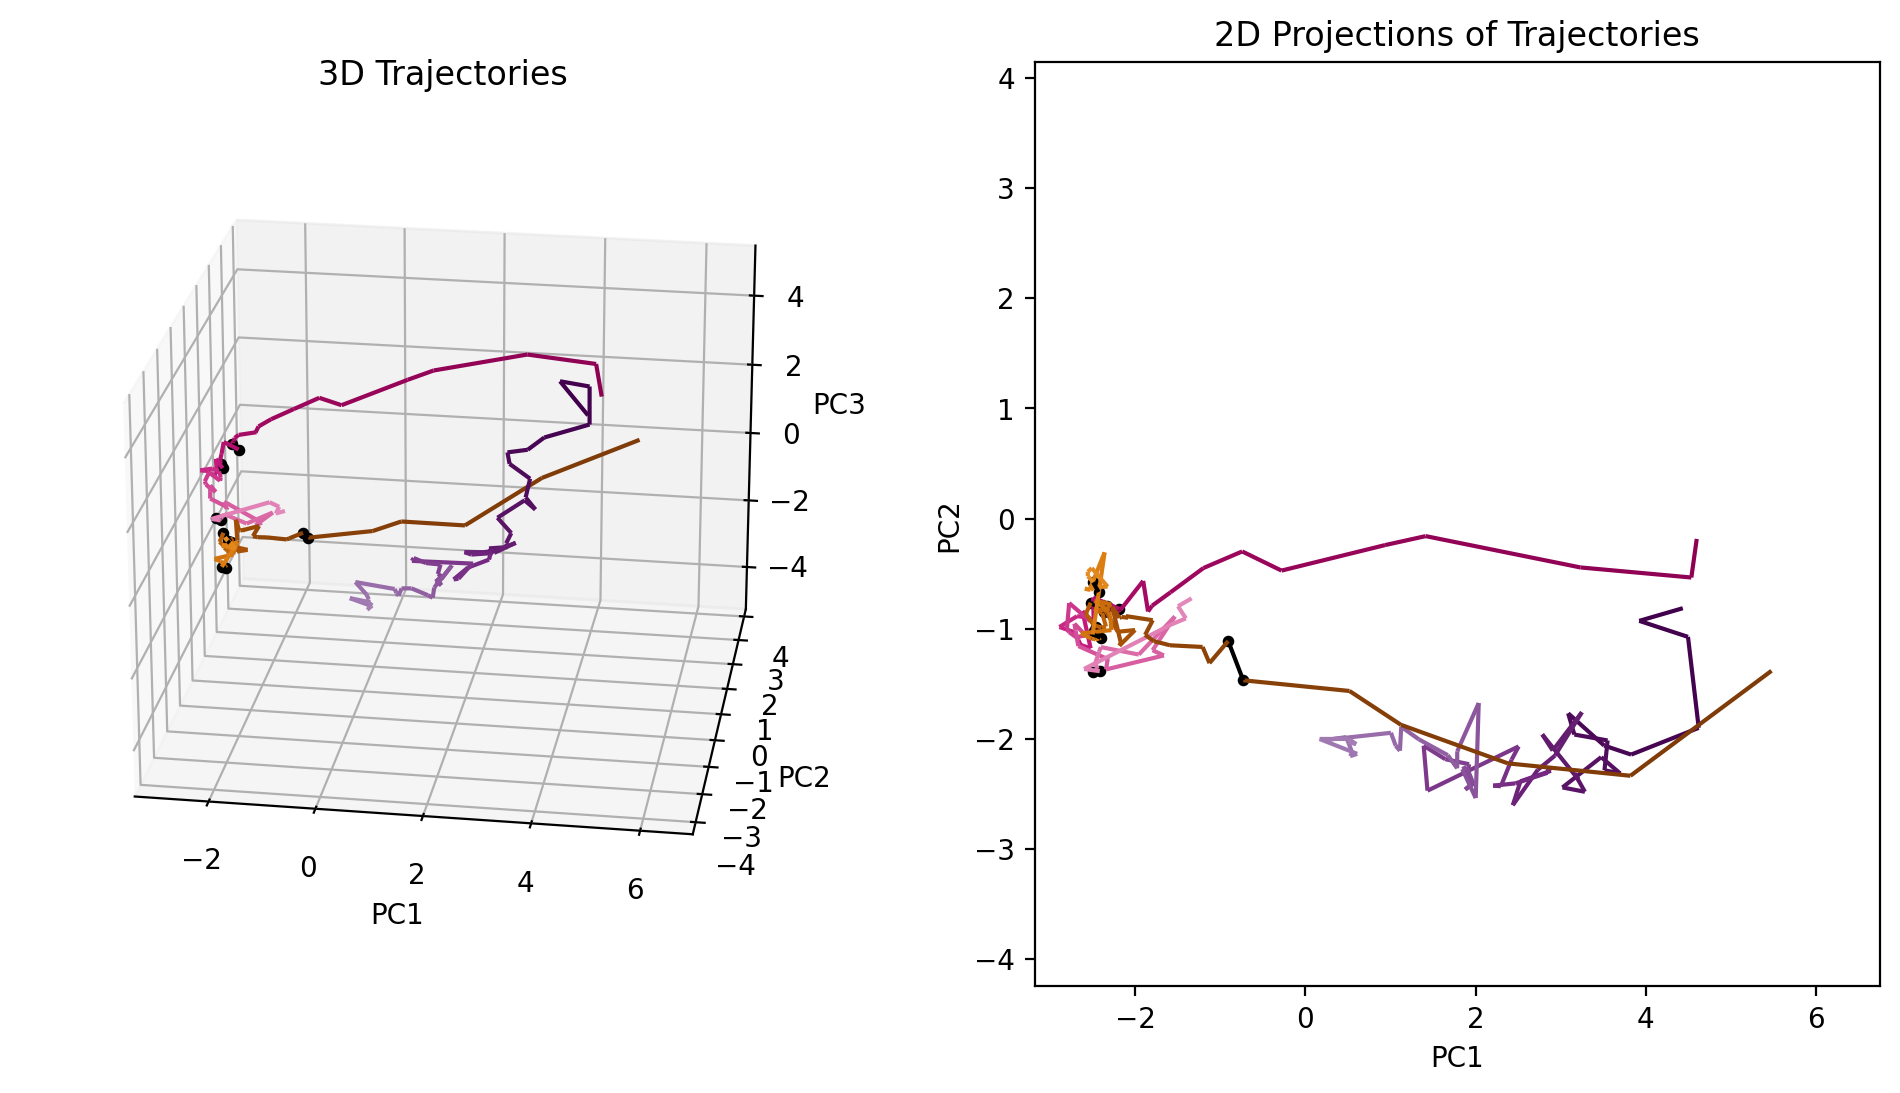

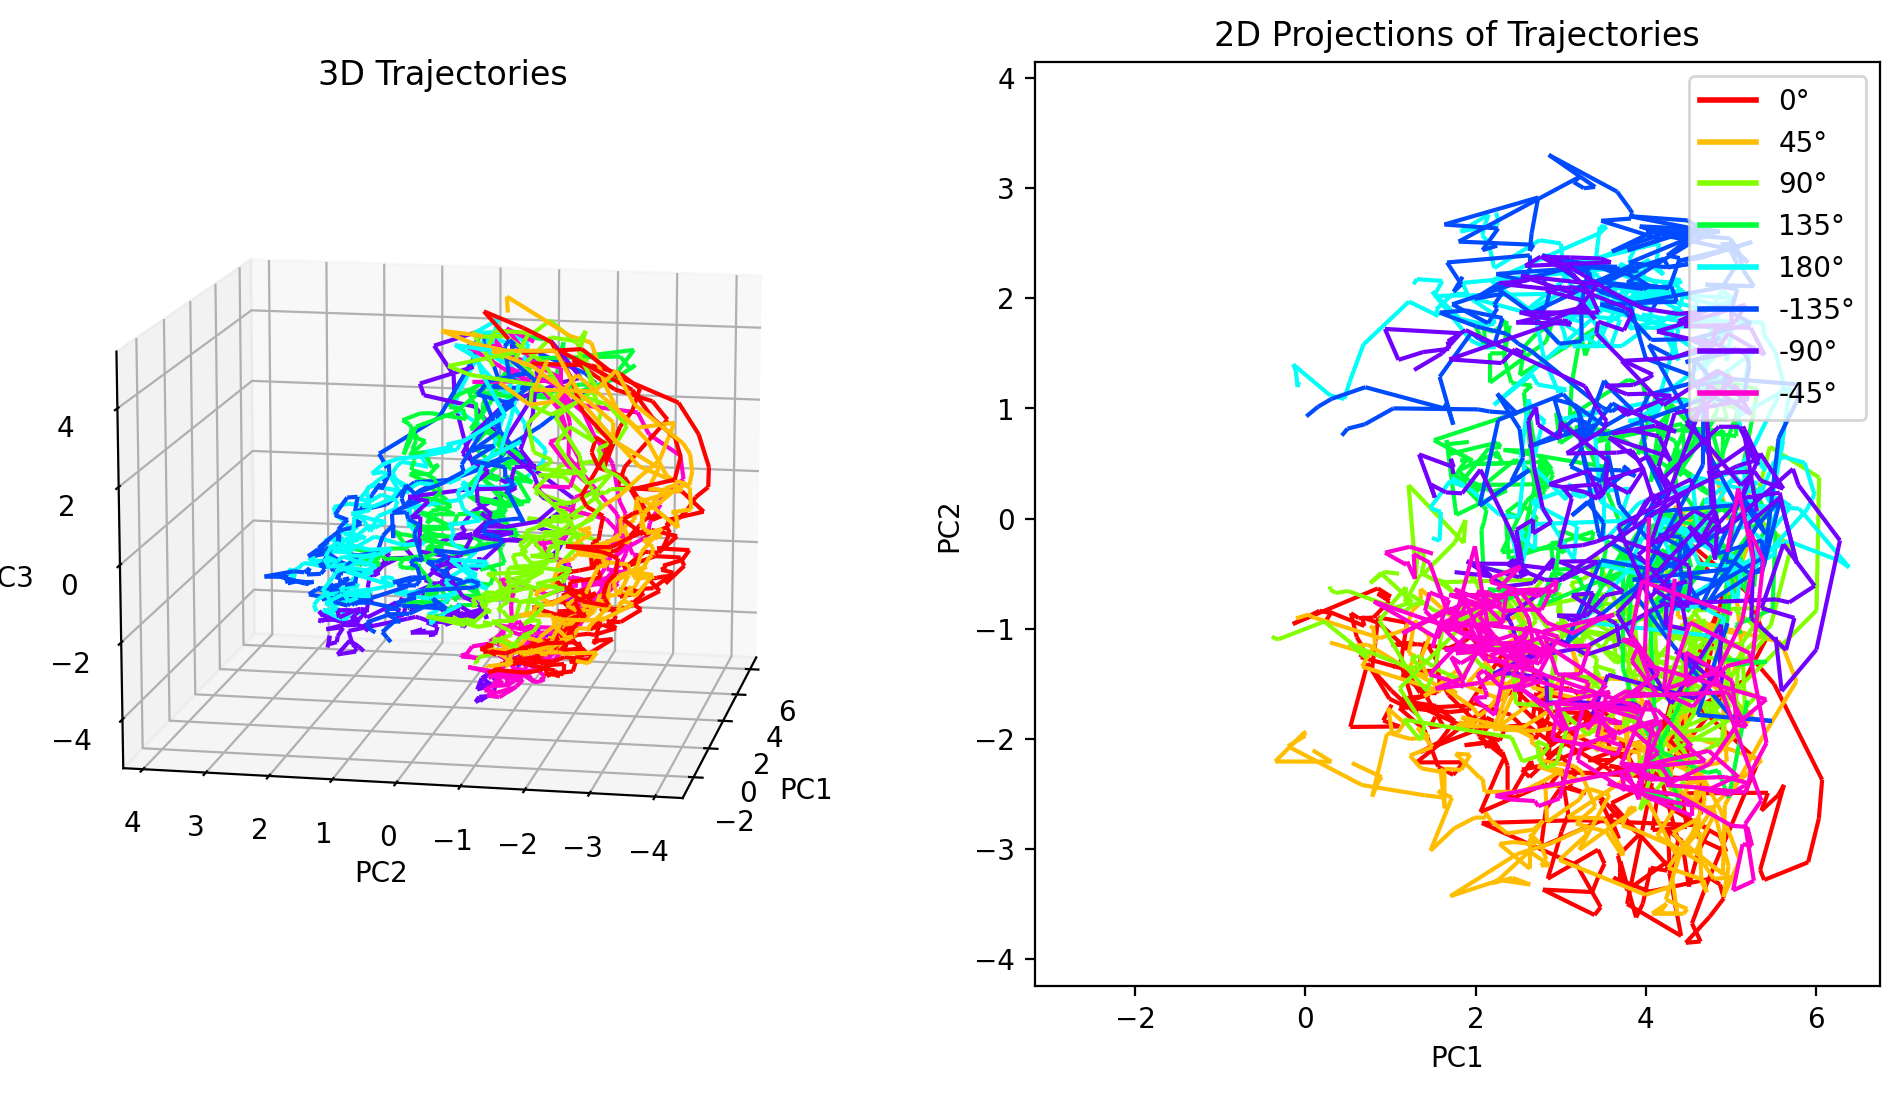

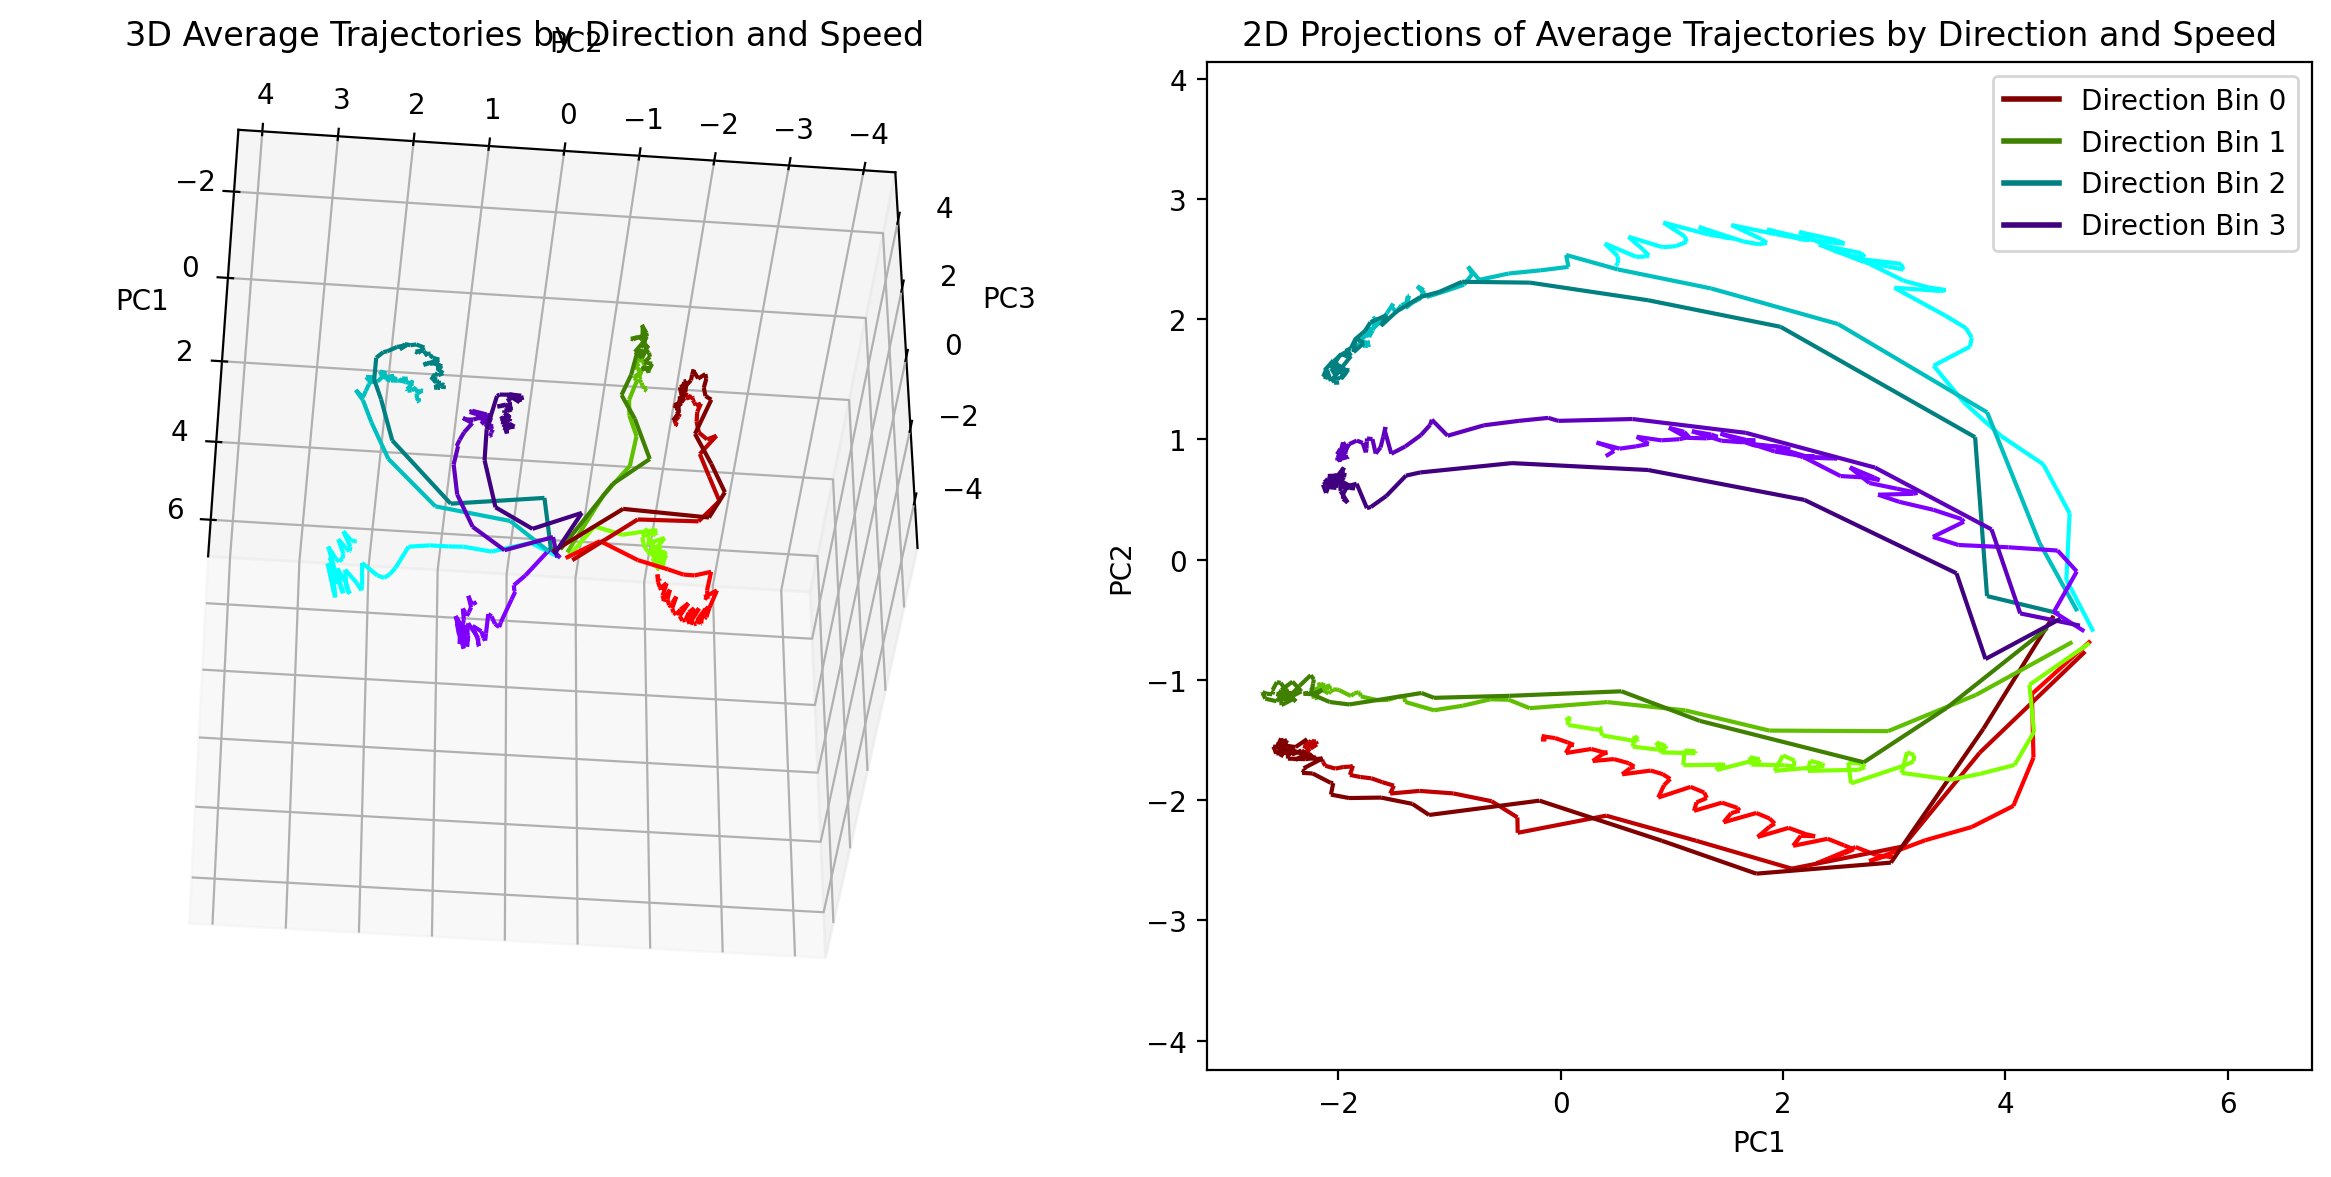

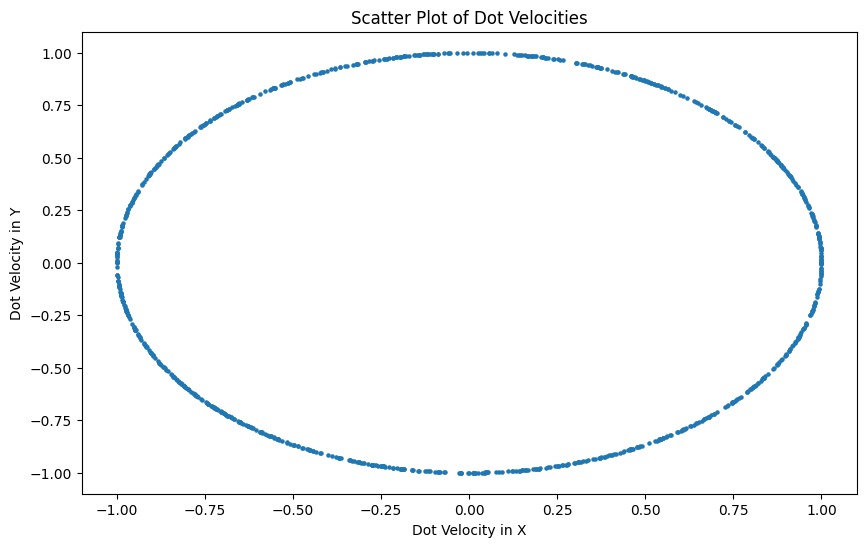

: 

In [15]:
# debug (dot vel scatter)

%matplotlib inline
dot_diffs = np.diff(dot_arr, axis=1)
mean_dot_vel = np.mean(dot_diffs, axis=1)
norm_dot_vel = np.linalg.norm(mean_dot_vel, axis=1)
mean_dot_vel = mean_dot_vel / norm_dot_vel[:,np.newaxis]
print('dot_diffs.shape=',dot_diffs.shape)
print('mean_dot_vel.shape=',mean_dot_vel.shape)
print('norm_dot_vel.shape=',norm_dot_vel.shape)
print('mean_dot_vel=',mean_dot_vel.shape)
# plot a scatter plot of the dot velocities:
plt.figure(figsize=(10,6))
plt.scatter(mean_dot_vel[:,0], mean_dot_vel[:,1], s=5)
plt.title("Scatter Plot of Dot Velocities")
plt.xlabel("Dot Velocity in X")
plt.ylabel("Dot Velocity in Y")

In [ ]:
# get_top_rewarded_trials fncs (old)

def get_top_rewarded_trials_old(dot_arr, r_arr, T, N):
    norms = np.linalg.norm(dot_arr, axis=2)
    normalized_dot_arr = dot_arr / norms[:, :, np.newaxis]
    bins = generate_bin_vectors(N)
    print('bins=',bins)
    
    # Create an array to store the top K trials for each bin
    top_trials = np.empty((T, N), dtype=int)

    # Calculate the sum of rewards for each trial
    total_rewards = np.sum(r_arr, axis=1)

    for idx, bin_val in enumerate(bins):
        print('bin_val=',bin_val)
        # Calculate the angle (cosine similarity) between each dot vector and the current bin vector
        cosine_similarity = normalized_dot_arr @ np.array(bin_val)
        
        # Convert cosine similarity to angular difference
        angular_diff = np.arccos(cosine_similarity)
        print('angular_diff=',angular_diff.shape)

        # print('min_ang_diff=',np.min(angular_diff, axis=1))

        # Check if this bin has the smallest angular difference for each dot vector
        is_closest_bin = np.isclose(angular_diff, np.min(angular_diff, axis=1)[:, np.newaxis])
        
        print(f"Number of trials closest to bin {idx}: {sum(is_closest_bin[:, 0])}")
        # Find the top K trials for the current bin
        sorted_indices = np.argsort(total_rewards[is_closest_bin[:, 0]])[::-1]
        top_trials[:, idx] = np.arange(1000)[is_closest_bin[:, 0]][sorted_indices[:T]]

    t = has_duplicates(top_trials)
    print('has duplicates=',t)

    return top_trials

def get_top_rewarded_trials(dot_arr, r_arr, T, N):
    norms = np.linalg.norm(dot_arr, axis=2)
    normalized_dot_arr = dot_arr / norms[:, :, np.newaxis]
    bins = generate_bin_vectors(N)
    
    # Store the trials for each bin in a list of lists
    bin_trials = [[] for _ in range(N)]

    for trial_idx, dots in enumerate(normalized_dot_arr):
        # Calculate the angle (cosine similarity) between this trial's dot vector and all bins
        cosine_similarity = dots @ bins.T
        angular_diff = np.arccos(cosine_similarity)
        # Get the index of the bin that has the smallest angular difference for this trial
        closest_bin_idx = np.argmin(angular_diff, axis=1)[0] 
        bin_trials[closest_bin_idx].append(trial_idx)
        
    top_trials = np.empty((T, N), dtype=int)
    total_rewards = np.sum(r_arr, axis=1)

    for idx, trials in enumerate(bin_trials):
        # Sort the trials in this bin based on their rewards and take the top T
        sorted_trials = sorted(trials, key=lambda x: total_rewards[x], reverse=True)
        top_trials[:, idx] = sorted_trials[:T]

    t = has_duplicates(top_trials)
    print('has duplicates=',t)

    return top_trials

In [ ]:
# old

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection

n = 335

def plot_trajectory(data, n):
    fig = plt.figure(figsize=(12, 6))
    
    # 3D Plot
    ax1 = fig.add_subplot(121, projection='3d')
    traj = data[n, :, :3]  # Considering top 3 PCs
    length = traj.shape[0]
    segments = [traj[i:i+2] for i in range(length-1)]
    lc_3d = Line3DCollection(segments, cmap=plt.cm.seismic, norm=plt.Normalize(0, length))
    lc_3d.set_array(np.linspace(0, length, len(segments)))
    ax1.add_collection(lc_3d)
    ax1.set_xlim(traj[:, 0].min(), traj[:, 0].max())
    ax1.set_ylim(traj[:, 1].min(), traj[:, 1].max())
    ax1.set_zlim(traj[:, 2].min(), traj[:, 2].max())
    ax1.set_title('3D Trajectory')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')

    # 2D Plot (assuming the plane of most variation involves the first and second PCs)
    ax2 = fig.add_subplot(122)
    segments_2d = [traj[i:i+2, :2] for i in range(length-1)]
    lc_2d = LineCollection(segments_2d, cmap=plt.cm.seismic, norm=plt.Normalize(0, length))
    lc_2d.set_array(np.linspace(0, length, len(segments_2d)))
    ax2.add_collection(lc_2d)
    ax2.autoscale_view()
    ax2.set_title('2D Projection')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')

    plt.tight_layout()
    plt.show()
    plt.close()

plot_trajectory(hs_pc_s, n)
# plot_trajectory(hv_pc_c, n)

